# Exploring Graph Connections between Wikipedia Pages

This notebook explores how to do two things:
1) Take a starting Wikipedia page and find all pages one degree away

2) Take an array of Wikipedia pages and calculate graph proximity scores between them

In [320]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Integrate Data

We bring in several CSVs provided as part of the KDWD.
- statements.csv: Truthy QPQ Wikidata item statements.
- property_aliases.csv: Wikidata property aliases in English.
- property.csv: Wikidata property labels and descriptions in English

In [2]:
# Integrate property.csv
property_df = pd.read_csv("../../data/kdkg/property.csv", delimiter=',', )
assert type(property_df) is not None
display(property_df.head(3))

,property_id,en_label,en_description
0,6,head of government,"head of the executive power of this town, city..."
1,10,video,"relevant video. For images, use the property P..."
2,14,traffic sign,"graphic symbol describing the item, used at th..."


In [3]:
# Integrate property_aliases.csv
property_alias_df = pd.read_csv("../../data/kdkg/property_aliases.csv", delimiter=',', )
assert type(property_alias_df) is not None
display(property_alias_df.head(3))

,property_id,en_alias
0,6,mayor
1,6,prime minister
2,6,premier


In [4]:
# Integrate statements.csv
statements_df = pd.read_csv("../../data/kdkg/statements.csv", delimiter=',', )
assert type(statements_df) is not None
display(statements_df.head(3))

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745


In [12]:
# Integrate page.csv
page_df = pd.read_csv("../../data/kdkg/page.csv", delimiter=',', )
assert type(page_df) is not None
display(page_df.head(3))

,page_id,item_id,title,views
0,12,6199,Anarchism,31335
1,25,38404,Autism,49693
2,39,101038,Albedo,14573


## Exploring Dataset

In [5]:
# Understand lengths of datasets
print(f"Properties: {len(property_df):,}")
print(f"Property Aliases: {len(property_alias_df):,}")
print(f"Statements: {len(statements_df):,}")

Properties: 6,985
Property Aliases: 9,004
Statements: 141,206,853


In [7]:
# Unique 
print(f"KDKG links {len(statements_df['source_item_id'].unique()):,} unique starting nodes\
      to {len(statements_df['target_item_id'].unique()):,} unique ending nodes.")

KDKG links 51,106,679 unique starting nodes to 3,778,904 unique ending nodes.


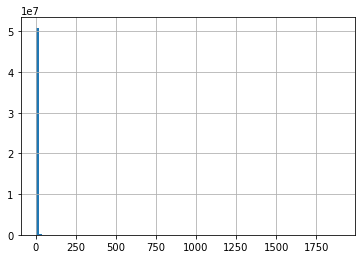

CPU times: user 24.7 s, sys: 58 s, total: 1min 22s
Wall time: 2min 2s


In [11]:
%%time
plt.figure(figsize=(20,5))
statements_df['source_item_id'].value_counts().hist(bins=100)
plt.xscale('log')
plt.show()

# Find First Degree Graph Connections

A first degree graph connection can be defined in one of two ways:
1) The page has a formal property linking it to another page. Properties are derived from the KDWD.

2) The page contains an anchor text that links it to another page.

### Exploring Formal Property Graph Connections

We have built this so that you can enter a Page ID. However, the statements connect nodes by Item ID. The pages.csv file has both as columns, but be cautious as to what you're linking on.

You can read more about the differences here: https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data?select=item.csv. But basically, an Item isn't a "node" in the way we're considering it for our Entity Disambiguation.

In [91]:
# Specify Wikipedia Page ID
source_page_id = 12

# Confirm Page ID in Page list
assert page_df['page_id'].isin([source_page_id]).sum() >= 1

In [82]:
# Find Wikipedia Item ID
source_item_id = page_df[page_df['page_id'] == source_page_id]['item_id'].item()
source_page_title = page_df[page_df['page_id'] == source_page_id]['title'].item()
print(source_page_title, " (", source_item_id, ")")

Anarchism  ( 6199 )


In [83]:
# Return all statements linking source_item_id to other pages
source_page_connections = statements_df[statements_df['source_item_id'] == source_item_id]
print(f"Found {len(source_page_connections)} linked pages by property. Sample below.")
display(source_page_connections.head(5))

Found 19 linked pages by property. Sample below.


,source_item_id,edge_property_id,target_item_id
168064,6199,61,5749
168065,6199,279,12909644
168066,6199,910,8549239
168067,6199,1151,8519616
168068,6199,1343,602358


In [84]:
# Return array of all linked Item IDs
linked_item_ids = np.array(source_page_connections['target_item_id'])
display(linked_item_ids)

array([    5749, 12909644,  8549239,  8519616,   602358,   867541,
        2041543,  3181656,  4173137, 19180675, 20743760,  6025383,
           7188,     7264,  2371005,  2746978, 29917753, 12961474,
        5460604])

In [85]:
# Return all linked pages for these item IDs
linked_page_ids = []
linked_page_titles = []
for i in linked_item_ids:
#     print(i)
    try:
        linked_page_ids.append(page_df[page_df['item_id'] == i]['page_id'].item())
        linked_page_titles.append(page_df[page_df['item_id'] == i]['title'].item())
    except:
        continue
print(f"We were able to link {len(linked_page_ids)} out of {len(linked_item_ids)} Item IDs back to Page IDs.")
print(linked_page_titles)

We were able to link 8 out of 19 Item IDs back to Page IDs.
['Pierre-Joseph Proudhon', 'Brockhaus and Efron Encyclopedic Dictionary', 'Encyclopædia Britannica Eleventh Edition', 'The Nuttall Encyclopædia', 'Government', 'Marxism', 'Anarchy (international relations)', 'History of anarchism']


In [102]:
##################################################
### Function to Retrieve First-Degree Page Connections
##################################################
def get_property_links(source_page_id):
    """
    This function asks you to enter a Page ID and will retrieve a list of all first-degree linked page IDs it can find.
    Inputs:
    - source_page_id: The Page ID you want to start from
    Note: Must have page.csv and statements.csv integrated beforehand.
    """
    # Confirm user entered a valid Page ID
    try:
        assert page_df['page_id'].isin([source_page_id]).sum() >= 1
    except AssertionError:
        print("That Page ID is not in the database.")
        return
    
    # Find Wikipedia Item ID
    source_item_id = page_df[page_df['page_id'] == source_page_id]['item_id'].item()
    source_page_title = page_df[page_df['page_id'] == source_page_id]['title'].item()
    print(f"Linking from page \"{source_page_title}\"")
    
    # Return all statements linking source_item_id to other pages
    source_page_connections = statements_df[statements_df['source_item_id'] == source_item_id]
    print(f"Found {len(source_page_connections)} linked pages by property. Sample below.")
    
    # Return array of all linked Item IDs
    linked_item_ids = np.array(source_page_connections['target_item_id'])
    
    # Return all linked pages for these item IDs
    linked_page_ids = []
    linked_page_titles = []
    for i in linked_item_ids:
        try:
            linked_page_ids.append(page_df[page_df['item_id'] == i]['page_id'].item())
            linked_page_titles.append(page_df[page_df['item_id'] == i]['title'].item())
        except:
            continue
    print(f"We were able to link {len(linked_page_ids)} out of {len(linked_item_ids)} Item IDs back to a Page ID (Entity).")
    print(linked_page_titles)
    
    return linked_page_ids

In [104]:
%%time
# Demo function: get_property_links()
get_property_links(303)

Linking from page "Alabama"
Found 120 linked pages by property. Sample below.
We were able to link 105 out of 120 Item IDs back to Page IDs.
['Kay Ivey', 'United States', 'North America', 'U.S. state', 'Montgomery, Alabama', 'English language', 'Florida', 'Georgia (U.S. state)', 'Mississippi', 'Tennessee', 'United States', 'Alabama people', 'Cherokee County, Alabama', 'Calhoun County, Alabama', 'Butler County, Alabama', 'Barbour County, Alabama', 'Blount County, Alabama', 'Choctaw County, Alabama', 'Bullock County, Alabama', 'Chilton County, Alabama', 'Clarke County, Alabama', 'Chambers County, Alabama', 'Jefferson County, Alabama', 'Morgan County, Alabama', 'Baldwin County, Alabama', 'Autauga County, Alabama', 'Clay County, Alabama', 'Cullman County, Alabama', 'Perry County, Alabama', 'Lauderdale County, Alabama', 'Talladega County, Alabama', 'Cleburne County, Alabama', 'Jackson County, Alabama', 'Bibb County, Alabama', 'Coffee County, Alabama', 'Conecuh County, Alabama', 'Covington C

[17539463,
 3434750,
 21139,
 18618239,
 57690,
 8569916,
 18933066,
 48830,
 16949861,
 30395,
 3434750,
 1461870,
 76957,
 76938,
 76933,
 76925,
 76928,
 76951,
 76932,
 76945,
 76955,
 76943,
 77868,
 77367,
 76924,
 76923,
 57769,
 77379,
 81299,
 80771,
 81317,
 77370,
 77857,
 76926,
 77369,
 77371,
 77375,
 77368,
 77372,
 77834,
 77377,
 77384,
 77381,
 77838,
 81303,
 77842,
 80784,
 77365,
 77837,
 77841,
 77827,
 77828,
 80796,
 77873,
 77872,
 81316,
 80779,
 81291,
 80787,
 81310,
 80780,
 77855,
 81322,
 80775,
 80788,
 81306,
 80783,
 58119,
 80795,
 81324,
 77366,
 81308,
 24102783,
 80782,
 81320,
 77870,
 81321,
 81318,
 81301,
 142713,
 3791177,
 2709449,
 4020699,
 3365958,
 83759,
 2453052,
 481638,
 1221238,
 863222,
 468280,
 1132901,
 13984112,
 677765,
 19387572,
 505888,
 2446456,
 21076367,
 34690407,
 8965092,
 4694788,
 39473,
 351590,
 1285,
 1278342,
 1276118]

## Exploring Anchor Link Graph Connections

Because this requires a different dataset, I have not defined a function to do this yet.

In [ ]:
pass

# Create a Knowledge Graph from KDKG Using NetworkX

We create an actual knowledge graph using the Python package `networkx` v2.5. This is what we'll ultimately use to determine node proximity.

This was helpful to read to understand how to use NetworkX: [What Is Knowledge Graph](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/).

We want to use [MultiGraph](https://networkx.org/documentation/stable/reference/classes/index.html), becauase it is undirected and allows parallel edges (/multiple links). While our relationships are directed, using undirected makes it simpler to calculate node proximity, instead of being forced to go all the way around.

#### Ingesting into Graph
NetworkX's function `from_pandas_edgelist` lets us plug statements.csv, which represents a row per edge, directly into NX to get back a graph.

#### Calculating path length between nodes
NetworkX's function `all_pairs_shortest_path` and `all_pairs_shortest_path_length` stores the shortest paths and lengths in a matrix `sp` that you can then query using syntax `sp[source_id, target_id]`.

You can also compute shortest paths on the fly using `shortest_path` or `shortest_path_length`, which involves querying with form `nx.shortest_path_pength(wiki_graph[source_id, target_id]`.

Check out more documentation [here](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html). 

In [179]:
#Import NetworkX
import networkx as nx

In [180]:
%%time
# Create a directed-graph from the statements_df
# edge_attr=True uses "all remaining columns used to retrieve items and add to graph as edge attributes"

# Using the entire dataframe at once is too big, so showing how to filter with just one page
wiki_graph = nx.from_pandas_edgelist(statements_df[statements_df['source_item_id'] == source_item_id],
                                     source="source_item_id", target="target_item_id",
                                     edge_attr=True, create_using = nx.MultiGraph())

CPU times: user 292 ms, sys: 1.32 s, total: 1.61 s
Wall time: 2.33 s


In [181]:
# Print number of nodes in graph
print("Number of nodes: ", wiki_graph.number_of_nodes())
print("Number of links: ", wiki_graph.number_of_edges())

Number of nodes:  20
Number of links:  19


#### Re-label nodes
It is possible to re-label nodes from integers to strings. I haven't done this for the full dataset, because I haven't finalized whether we should be making networks of pages or items (and item.csv is a really large file). Below is a toy example.

Check out documentation [here](https://networkx.org/documentation/stable/reference/generated/networkx.relabel.relabel_nodes.html#networkx.relabel.relabel_nodes).

In [182]:
# Relabel nodes from Item IDs to Item Title
# You must pass in a dictionary as mapping.
# Create dictionary
mapping = {}
for i in np.append(linked_item_ids, source_item_id):
    try:
        title = page_df[page_df['item_id'] == i]['title'].item()
#         print(title)
        mapping[i] = title
    except:
        continue
print(mapping)

{5749: 'Pierre-Joseph Proudhon', 602358: 'Brockhaus and Efron Encyclopedic Dictionary', 867541: 'Encyclopædia Britannica Eleventh Edition', 3181656: 'The Nuttall Encyclopædia', 7188: 'Government', 7264: 'Marxism', 2371005: 'Anarchy (international relations)', 2746978: 'History of anarchism', 6199: 'Anarchism'}


In [183]:
# Update garph with relabeled nodes
# This toy example won't match on all because I'm adding title to item from page, not from item
wiki_graph = nx.relabel_nodes(wiki_graph, mapping)

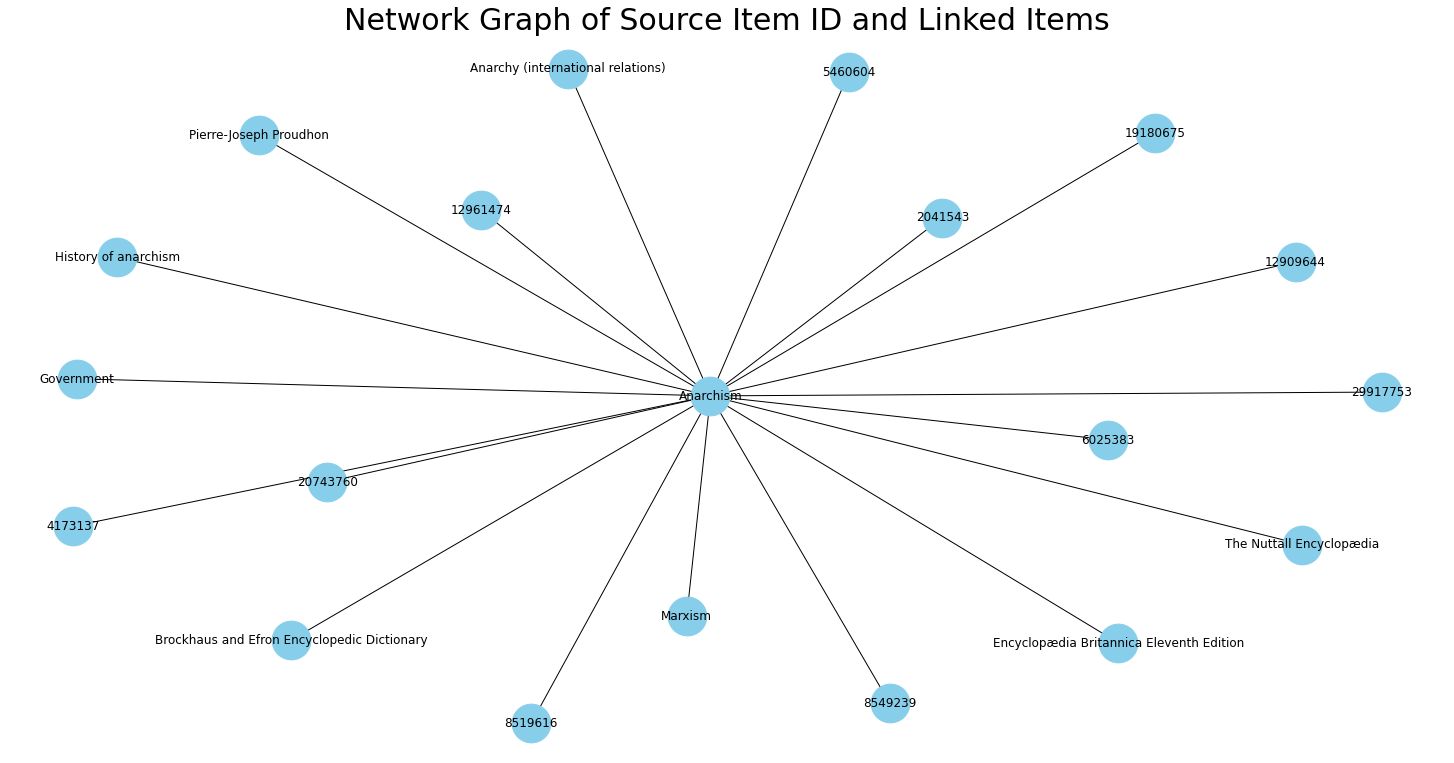

In [184]:
# Display filtered network graph for our source page
plt.figure(figsize=(20,10))
pos = nx.spring_layout(wiki_graph, k = 0.1) # k regulates the distance between nodes
nx.draw(wiki_graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.title("Network Graph of Source Item ID and Linked Items", size=30)
plt.show()

In [185]:
# Calculate distance between two nodes
print("Shortest Path Between Sample Nodes: ", nx.shortest_path_length(wiki_graph, source="Marxism", target=29917753))
print("Shortest Path Between Sample Nodes: ", nx.shortest_path(wiki_graph, source="Marxism", target=29917753))

Shortest Path Between Sample Nodes:  2
Shortest Path Between Sample Nodes:  ['Marxism', 'Anarchism', 29917753]


### Calculating SimRank similarity
Read about algorithm on [Wikipedia](https://en.wikipedia.org/wiki/SimRank). "Two objects are considered to be similar if they are referenced by similar objects."

This was the best measure of node-to-node similarity I could find in the documentation, but check out more options [here](https://networkx.org/documentation/stable/reference/algorithms/index.html).

In [188]:
# Calculate SimRank
print("SimRank Similarity: ", nx.simrank_similarity(wiki_graph, source="Marxism", target=29917753))
print("SimRank Similarity: ", nx.simrank_similarity(wiki_graph, source="Marxism", target=12909644))
print("SimRank Similarity: ", nx.simrank_similarity(wiki_graph, source="Marxism", target="Anarchism"))

SimRank Similarity:  0.9
SimRank Similarity:  0.9
SimRank Similarity:  0.0


# Generating Graphs from Candidate Entities

Our problem is now a computational one. We cannot simply load in the entire statements_df into a graph. It is much too big. We can load in just the First-Degree Page Connections to a candidate entity, but that doesn't guarantee overlapping connections between two separate networks, each from a separate candidate entity.

We must design a way to iteratively develop a graph until we reach some level of overlap that we define...

In [369]:
###########################################################
### Function to Create Graph from Source Node to N Degree
###########################################################
def network_to_n_degree(network_seeds, N=2, plot_node_growth=False):
    """
    This function asks you to enter an Item ID or a list of Item IDs and will return a constructed graph to N degrees
    It includes a number of performance metrics like node growth and search time
    Inputs:
    - source_item_id: single digit or list/array to seed the graph
    - N: Number of degrees to which we should search
    Outputs:
    - NetworkX Graph object
    Note: Requires previous import of statements_df
    """
    
    if not isinstance(network_seeds, (list, np.ndarray)):
        network_seeds = [network_seeds]
        
    if plot_node_growth:
        plt.figure(figsize=(10,4))
        plt.title("Node Growth By Degree")
        plt.xlabel("Degrees")
        plt.ylabel("Count of Nodes")
        
    
    network_edgelist = pd.DataFrame(columns=statements_df.columns)
    
    for seed in network_seeds:
        
        print("*********************")
        print("Searching for seed {}".format(seed))

        # Return First Degree Connections to seed edge list
        print("Calculating Degree 1 Connections")
        start_time = time.time()
        first_degree_connections = statements_df[statements_df['source_item_id'] == seed]
        connections_list = first_degree_connections['target_item_id']

        # Keep track of metrics
        start = 0
        end = len(connections_list)
        node_counts = [1]
        node_counts.append(len(connections_list))
        print("Degree took {}s to compute for {} nodes".format(round(time.time()-start_time,1), end-start))

        # For N degrees, loop over connections and return
        for i in range(2, N+1):
            start_time = time.time()
            print("Calculating Degree {} connections".format(i))
    #         print(start, end)
            for item in connections_list[start:end]:
    #             print(item)
                Nth_degree_connections = statements_df[statements_df['source_item_id'] == item]
                first_degree_connections = first_degree_connections.append(Nth_degree_connections)
                if i <= N:
                    connections_list = connections_list.append(Nth_degree_connections['target_item_id'])
            start = end
            end = len(connections_list)
            if plot_node_growth:
                node_counts.append(len(connections_list))
            print("Degree took {}s to compute for {} nodes".format(round(time.time()-start_time,1), end-start))
        
        
        # Add to returned dataframe
        network_edgelist = network_edgelist.append(first_degree_connections)

        if plot_node_growth:
            plt.plot(range(N+1), node_counts, lw=3, label=seed)
            
    
    if plot_node_growth:
        plt.legend()
        plt.show()
    
    # Create NetworkX Graph object from DataFrame
    G = nx.from_pandas_edgelist(network_edgelist,
                                     source="source_item_id", target="target_item_id",
                                     edge_attr=True, create_using = nx.MultiGraph())
    
    return G
        

*********************
Searching for seed 6199
Calculating Degree 1 Connections
Degree took 0.2s to compute for 19 nodes
Calculating Degree 2 connections
Degree took 3.9s to compute for 270 nodes
*********************
Searching for seed 19134281
Calculating Degree 1 Connections
Degree took 0.2s to compute for 4 nodes
Calculating Degree 2 connections
Degree took 1.0s to compute for 161 nodes


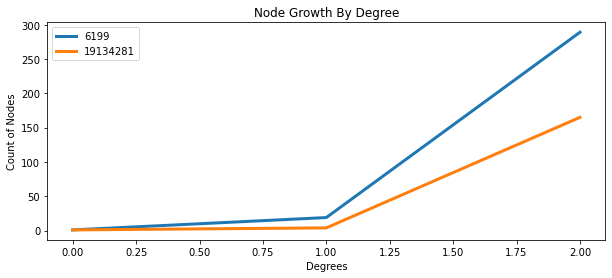

CPU times: user 4.17 s, sys: 1.29 s, total: 5.46 s
Wall time: 5.66 s


In [371]:
%%time
# Entered two manually found seeds
N_degree_G = network_to_n_degree([source_item_id, 19134281], N=2, plot_node_growth=True)

In [372]:
# Print number of nodes in graph
print("Number of nodes: ", N_degree_G.number_of_nodes())
print("Number of links: ", N_degree_G.number_of_edges())

Number of nodes:  388
Number of links:  454


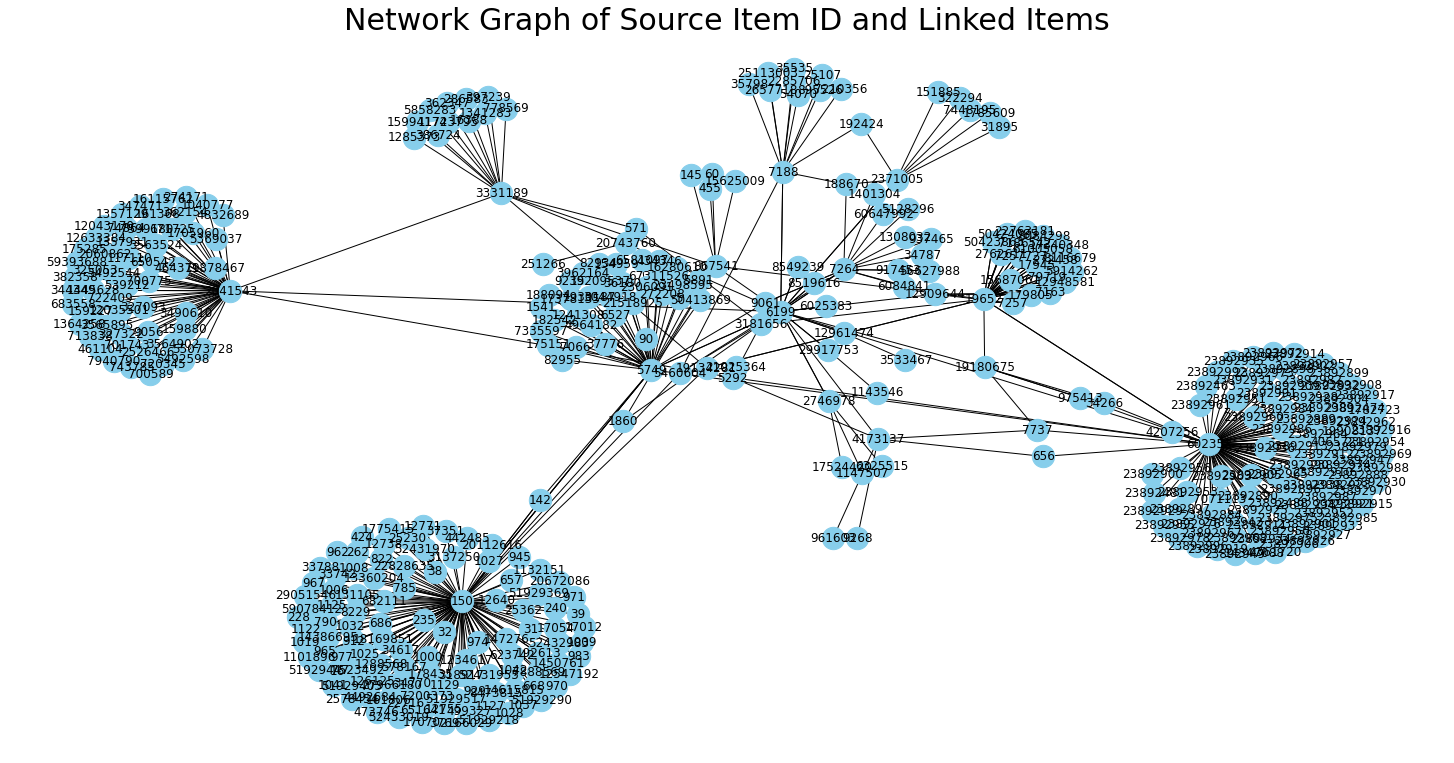

CPU times: user 1.56 s, sys: 398 ms, total: 1.95 s
Wall time: 2.04 s


In [373]:
%%time
# Display filtered network graph for our source page
plt.figure(figsize=(20,10))
pos = nx.spring_layout(N_degree_G, k = 0.1) # k regulates the distance between nodes
nx.draw(N_degree_G, with_labels=True, node_color='skyblue', node_size=500, edge_cmap=plt.cm.Blues, pos=pos)
plt.title("Network Graph of Source Item ID and Linked Items", size=30)
plt.show()

In [374]:
%%time
# Calculate shortest distance between all nodes
# Returns a generator so must save as dict
path_lengths = dict(nx.all_pairs_shortest_path_length(N_degree_G))

CPU times: user 214 ms, sys: 399 ms, total: 614 ms
Wall time: 1.07 s


In [380]:
%%time
# Retrieve pre-calculated path length between any two nodes
path_lengths[235][151885]

# In terms of performance, this calculates MUCH faster.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


5

In [379]:
%%time
# Calculate SimRank
print("SimRank Similarity: ", nx.simrank_similarity(N_degree_G, source=235, target=151885))

SimRank Similarity:  0.026838716367778168
CPU times: user 53.4 s, sys: 235 ms, total: 53.7 s
Wall time: 54.2 s
